In [1]:
#Loading required modules
import os
import shutil
import subprocess
from subprocess import Popen, PIPE, CalledProcessError
import psycopg2 as db
import psycopg2.extras
from psycopg2 import sql
from psycopg2.extensions import AsIs
from encrypt import decryptCredentials,decryptString
#from procedures import refreshProcedures
import yaml
import getpass
import time
import re
import pandas as pd
import pickle

from shapely.wkb import loads
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry.point import Point
from shapely.ops import cascaded_union
from geopy.distance import distance

import metnoRequests as metno
import instantiationBasin as basin

import json
import gmaps
import gmaps.geojson_geometries
import geojson

#Helper function
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def get_basin_layers(schema,table,column,color='blue',sid=-9999):
    conn = db.connect("dbname={} user={} host={} password={}".format(credentials['database'],
                                                                       credentials['username'],
                                                                        credentials['host'],
                                                                        credentials['password']
                                                                      )
                       )
    #And a test query
    cursor = conn.cursor()
    cursor.execute(''' SELECT json_build_object(
                        'type', 'FeatureCollection',

                        'features', json_agg(
                            json_build_object(
                                'type',       'Feature',
                                'label',      station_name,
                                'geometry',   ST_AsGeoJSON(ST_ForceRHR(St_Transform(%(column)s,4326)))::json,
                                'properties', jsonb_set(row_to_json(%(table)s)::jsonb,'{%(column)s}','0',false)
                                )
                            )
                       )
                        FROM %(schema)s.%(table)s;  ''',{
                        'schema' : AsIs(schema) ,
                        'table'  : AsIs(table),
                        'column' : AsIs(column),
                         }
                  )
    layer=cursor.fetchone()[0]
    basin_layer = gmaps.geojson_layer(layer,fill_color=color)
    #conn.commit()
    
    cursor.execute('''SELECT a.station_name, st_x(st_transform(a.outlet,4326)),
                  st_y(st_transform(a.outlet,4326)), st_area(b.basin)
                  FROM %(schema)s.demShp AS a
                  INNER JOIN %(schema)s.%(table)s AS b 
                  ON a.station_id = b.station_id;''',{
                    'schema' : AsIs(schema),
                    'table' : AsIs(table),
                    }
                  )  

    rows=cursor.fetchall()
    #conn.commit()
    #conn.close()
    outlets = []
    for row in rows:
        #print(row)
        currentDict = {"name" : row[0], "location": (row[2],row[1]), "area": row[3]/1000000}
        outlets.append(currentDict)

    outlet_locations = [outlet["location"] for outlet in outlets]
    outlet_names = [outlet['name'] for outlet in outlets]
        
    info_box_template = """
    <dl>
    <dt>Name</dt><dd>{name}</dd>
    <dt>Area</dt><dd>{area} km<sup>2</sup></dd>
    </dl>
    """                                                
    outlet_info = [info_box_template.format(**outlet) for outlet in outlets]                                                 
    marker_layer = gmaps.marker_layer(outlet_locations, 
                                      info_box_content=outlet_info,
                                      hover_text=outlet_names)    
    
    if sid != -9999 :
        cursor.execute('''SELECT %(column)s FROM %(schema)s.%(table)s
                      WHERE station_id = %(sid)s;'''
                      ,{
                        'schema' : AsIs(schema),
                        'table'  : AsIs(table),
                        'column' : AsIs(column),
                        'sid'    : AsIs(sid)
                          
                    }
                  )
        box = cursor.fetchone()
        basin = loads(box[0], hex=True)
        basin = cascaded_union(basin)        
        return basin_layer,marker_layer,basin
            
    conn.close()    
    return basin_layer,marker_layer   

## Creating instance to compute basin

In [2]:
instance = 'prognos-basin'
username = 'jose-luis'
keyDir = 'prognosBasin'
region = 'europe-west3-a'
machineType = 'n1-standard-2'

basinGenerator = basin.basin(instance,username,region,keyDir,machineType)
basinGenerator.instantiate()
print("The ip of the google cloud instance is {}".format(basinGenerator.ip))

#Testing connection to instance
time.sleep(2) #Giving time for the editing to work
if basinGenerator.instanceExists:
    p = Popen("ssh -i {0}/{1} {1}@{2} -o UserKnownHostsFile=/dev/null -o StrictHostKeyChecking=no".format(
            basinGenerator.keyDir,
            basinGenerator.username,
            basinGenerator.ip
            ),
            shell=True,stdout=PIPE,stdin=PIPE)
    print(p.communicate())

time.sleep(2)

The ip of the google cloud instance is 35.246.176.141
(b'Linux prognos-basin 4.9.0-6-amd64 #1 SMP Debian 4.9.88-1+deb9u1 (2018-05-07) x86_64\n\nThe programs included with the Debian GNU/Linux system are free software;\nthe exact distribution terms for each program are described in the\nindividual files in /usr/share/doc/*/copyright.\n\nDebian GNU/Linux comes with ABSOLUTELY NO WARRANTY, to the extent\npermitted by applicable law.\n', None)


# Meteo data
In this notebook, we'll get the catchment extent for Langtjern and will download meteo data from a nearby wheater station
## Setting up credentials and connecting to database

In [3]:
#Setting up credentials for database access. These should have been previously encrypted
token = b'gAAAAABayyyn8ZnEstm8ZQqClUYQ-IqFFuMO4QTbmFJADHWBAcirh52s5stDwSwtVK7qVm5tzdTNFxTQjuRF28b1t2rosFSl_nnTowWrD4itOjkzF7s6Kg_qa1Adqpj59OAfBapgkToUQUHvEFY1Njc4he36AC76gmb8t0CJCq4ze2pDHWIlGdDacZxQ1jq14uLVxrFfCTSxDPX8Mx9W1av723etkOdWvw=='
key = getpass.getpass('Password: ')
credentials = decryptCredentials(token,key)
credentials['host'] = basinGenerator.ip #This is because we don't have a static address for the host. A static address is provided if one uses catchment.niva.no

#Setting up credentials for google maps api access
apiToken = b'gAAAAABaXyLsGnF3ms4sC3ZhoLCwWAx9q0tydWl8XKEwOy8CO0W6Eqc8J4om8HNDlNR9nExYCmSrelp8W5R-PLtcce1I2UgW3YnlXXqWvrMN-outYwXhZoc59djfF752mzOPqXBHgpNC'
apiKey = decryptString(apiToken,key)
gmaps.configure(api_key=apiKey)

metnoToken = b'gAAAAABaYEqld0O48m09jEyMUBFTdBmZA2BVey2r7FKbo_7zrJPOa1aEGcpW0WmnhGVJHYUPm32f8ttaiboXxAF-Q9hDat3lhsa4ELzrT6J_e402kRDmWi6k0kpldOC2LTBNM9vNLLF4'
metnoKey = decryptString(metnoToken, key)
metno.init(metnoKey,'https://frost.met.no')

# Testing connection to database
try : 
    conn = db.connect("dbname={} user={} host={} password={}".format(credentials['database'],credentials['username'],credentials['host'],credentials['password']))
    print('Connection successful!')
except :
    print("Unable to connect")
    
conn.close()   

Password:  ·······


Connection successful!


## Setting station outlet

In [4]:
## Setting up outlet
station_name = 'Langtjern'
latitude = 60.3724626431
longitude = 9.7266598416
epsg = 4326
buffer = 5000
station_id = 12

stationData = (station_name,
               station_id,
               longitude,
               latitude,
               buffer,
               str(epsg),
               ''
              )

## Delineating basin

In [5]:
# Connecting as user specified in credentials
conn = db.connect("dbname={} user={} host={} password={}".format(credentials['database'],
                                                                       credentials['username'],
                                                                        credentials['host'],
                                                                        credentials['password']
                                                                      )
                       )
#And a test query
cursor = conn.cursor()

db.extras.register_composite('station_info',cursor)

#Re-arranging data as a list of tuples and passing it to pg with the help
#of pyscopg2 extras
allStations = list()
allStations.append(stationData)

print(allStations)
cursor.execute("SELECT procedures.initializeStations();")
conn.commit()

cursor.execute("SELECT procedures.addStations( %s::station_info[] );",(allStations,))
conn.commit()


resultsSchema = 'Prognos'


cursor.execute("SELECT procedures.initializeResultsSchema( %s );",(resultsSchema,))
conn.commit()

#Creating table to store base data and results
dataTable = 'dem'
print('Creating base data...')
cursor.execute(" SELECT procedures.createDataTable(%s,%s);", (resultsSchema,dataTable))
conn.commit()

resultsTable = 'results'
cursor.execute("SELECT procedures.createResultsTable(%s,%s);",(resultsSchema,resultsTable));
conn.commit()

conn.close()


with Popen(['fab', '-f', basinGenerator.fabCatchment, 'processSingleBasin:{},{},{},{},{},{},{},{},{}'.format(
                                                             credentials['username'],
                                                             credentials['password'],
                                                             credentials['database'],
                                                             resultsSchema,
                                                             dataTable,
                                                             'flow_dir',
                                                             'outlet',
                                                             '/home/jose-luis/Trash{}/'.format(station_id),
                                                             station_id
                                                             )
               ], stdout=PIPE, bufsize=1, universal_newlines=True) as p:
            #for line in p.stdout:
            #    print(line, end='') 

            if p.returncode != ( 0 or None):
                raise subprocess.CalledProcessError(p.returncode, p.args)
            print("Wa-wa-wee-wa",p.returncode)
            p.wait()     


[('Langtjern', 12, 9.7266598416, 60.3724626431, 5000, '4326', '')]
Creating base data...
Wa-wa-wee-wa None


In [6]:
#Get basin as shape
langtjern_layer,marker_layer,basin = get_basin_layers(resultsSchema,resultsTable + 'Shp',
                                            'basin',
                                            color='green',
                                            sid=station_id
                                                 )
fig = gmaps.figure()
fig.add_layer(langtjern_layer)
fig.add_layer(marker_layer)

buffer_layer,marker_layer,buffer = get_basin_layers(resultsSchema,resultsTable + 'Shp',
                                            'ST_Transform(ST_SimplifyPreserveTopology(ST_Buffer(basin,100000),3000),4326)',
                                           color=(0,100,50,0.2),
                                           sid=station_id
                                          )
fig.add_layer(buffer_layer)
fig

Figure(layout=FigureLayout(height='420px'))

## Getting available data in nearby stations



In [7]:
allStations = metno.getAvailableDatasets()

In [8]:
stationIds = list(set([i['sourceId'][:-2] for i in allStations['data'] if 'SN' in i['sourceId']]))
#The list is too long for a single query, let's split it
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
allCoordinates = []
for i in chunks(stationIds,100):
    data = metno.getCoordinates(i)
    allCoordinates.extend(data['data'])

### Fiinding nearby stations with meteo variables, given a time period

In [9]:
now = pd.to_datetime('today').strftime('%Y-%m-%d')
datesToGet = '2010-01-01/{}'.format(now)
start = datesToGet.split('/')
finish = pd.datetime.strptime(start[1],'%Y-%m-%d')
start = pd.datetime.strptime(start[0],'%Y-%m-%d')

def hasInfo(variable,timeResolution='PT1H'):
    stationsWithVariable = [i for i in allStations['data'] if variable == i['elementId']
                           and 'SN' in i['sourceId']
                           and start >= pd.datetime.strptime(i['validFrom'],'%Y-%m-%dT%H:%M:%S.%fZ')
                           and (finish <= pd.datetime.strptime(i['validTo'],'%Y-%m-%dT%H:%M:%S.%fZ') if 'validTo' in i else True) 
                           and i['timeResolution'] == timeResolution
                           ]
    #Getting rid of repeated stations
    stationsWithVariable = {i['sourceId']:i for i in stationsWithVariable}.values()
    #Combining with station metada
    stationsWithVariable = [  
        {"name" : b['name'], 
         "location" : b['geometry']['coordinates'][::-1], 
          "id" : a['sourceId'],
          "validFrom" : a['validFrom'],
          "variable" : a['elementId'],
          "distance" : "{:0.2f}".format(distance([longitude,latitude], b['geometry']['coordinates']).km)
        } #dict(a,**b) 
        for a in stationsWithVariable for b in allCoordinates if a['sourceId'][:-2] == b['id']
        and (Point(b['geometry']['coordinates']).within(buffer) if 'geometry' in b else False)
    ]
    #station = Point(metadata['geometry']['coordinates'])
         
    return stationsWithVariable

def getMarkerLayer(stations):
    info_box_template = """
    <dl>
    <dt>Met station</dt><dd>{name}</dd>
    <dt>id</dt><dd>{id}</dd>
    <dt>valid from</dt><dd>{validFrom}</dd>
    <dt>variable</dt><dd>{variable}</dd>
    <dt>distance</dt><dd>{distance} km</dd>
    </dl>
    """    
    station_locations = [station["location"] for station in stations]
    station_names = [station["name"] for station in stations]
    station_info = [info_box_template.format(**station) for station in stations]                                                 
    return gmaps.marker_layer(station_locations, info_box_content=station_info,hover_text=station_names)

varStations = {}
numStations = 3

In [10]:
humStations = hasInfo('mean(relative_humidity PT1H)')
varStations['humidity'] = sorted(humStations, key=lambda k: k['distance'])[:numStations] 

fig = gmaps.figure()
fig.add_layer(buffer_layer)
fig.add_layer(langtjern_layer)
fig.add_layer(getMarkerLayer(humStations))
fig

Figure(layout=FigureLayout(height='420px'))

In [11]:
windStations = hasInfo('wind_speed')
#Getting data only for the three closest stations
varStations['wind_speed'] = sorted(windStations, key=lambda k: float(k['distance']))[:numStations] 

fig = gmaps.figure()
fig.add_layer(getMarkerLayer(windStations))
fig.add_layer(buffer_layer)
fig.add_layer(langtjern_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [12]:
windDirStations = hasInfo('wind_from_direction')
varStations['wind_direction'] = sorted(windDirStations, key=lambda k: float(k['distance']))[:numStations] 

fig = gmaps.figure()
fig.add_layer(getMarkerLayer(windDirStations))
fig.add_layer(buffer_layer)
fig.add_layer(langtjern_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [13]:
radStations = hasInfo('mean(surface_downwelling_shortwave_flux_in_air PT1H)')
varStations['radiation'] = sorted(radStations, key=lambda k: float(k['distance']))[:numStations] 

fig = gmaps.figure()
fig.add_layer(getMarkerLayer(radStations))
fig.add_layer(buffer_layer)
fig.add_layer(langtjern_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [14]:
pressStations = hasInfo('air_pressure_at_sea_level')
varStations['air_pressure'] = sorted(pressStations, key=lambda k: float(k['distance']))[:numStations] 

fig = gmaps.figure()
fig.add_layer(getMarkerLayer(pressStations))
fig.add_layer(buffer_layer)
fig.add_layer(langtjern_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [15]:
tempStations = hasInfo('air_temperature')
varStations['air_temperature'] = sorted(tempStations, key=lambda k: float(k['distance']))[:numStations] 

fig = gmaps.figure()
fig.add_layer(getMarkerLayer(tempStations))
fig.add_layer(buffer_layer)
fig.add_layer(langtjern_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [16]:
cloudStations = hasInfo('cloud_area_fraction',timeResolution='PT6H')
varStations['cloud_cover'] = sorted(cloudStations, key=lambda k: float(k['distance']))[:numStations] 

fig = gmaps.figure()
fig.add_layer(getMarkerLayer(cloudStations))
fig.add_layer(buffer_layer)
fig.add_layer(langtjern_layer)
fig

Figure(layout=FigureLayout(height='420px'))

## Downloading data for the three nearest stations

#### Downloading data from station

In [17]:
def getData(stations):
    data={}
    instantiated=False
    for station in stations:
        df,junk = metno.downloadData(station['id'],
                                      station['variable'],
                                      datesToGet)
        #print(df.describe())
        if instantiated is False:
            data=df
            instantiated=True
        else:
            data=pd.merge(data,df,left_index = True, right_index = True, how = 'outer')
    return data

allData = {}
for key, stations in varStations.items():
    display('Downloading {} data'.format(key))
    allData[key] = getData(stations)
    


'Downloading humidity data'

Started download of mean(relative_humidity PT1H) in SN23500:0...
Done!
Started download of mean(relative_humidity PT1H) in SN12550:0...
Done!
Started download of mean(relative_humidity PT1H) in SN11500:0...
Done!


'Downloading wind_speed data'

Started download of wind_speed in SN24710:0...
Done!
Started download of wind_speed in SN20301:0...
Done!
Started download of wind_speed in SN24890:0...
Done!


'Downloading wind_direction data'

Started download of wind_from_direction in SN24710:0...
Done!
Started download of wind_from_direction in SN20301:0...
Done!
Started download of wind_from_direction in SN24890:0...
Done!


'Downloading radiation data'

Started download of mean(surface_downwelling_shortwave_flux_in_air PT1H) in SN23500:0...
Done!
Started download of mean(surface_downwelling_shortwave_flux_in_air PT1H) in SN18700:0...
Done!
Started download of mean(surface_downwelling_shortwave_flux_in_air PT1H) in SN12550:0...
Done!


'Downloading air_pressure data'

Started download of air_pressure_at_sea_level in SN20301:0...
Done!
Started download of air_pressure_at_sea_level in SN24890:0...
Done!
Started download of air_pressure_at_sea_level in SN28380:0...
Done!


'Downloading air_temperature data'

Started download of air_temperature in SN24710:0...
Done!
Started download of air_temperature in SN20301:0...
Done!
Started download of air_temperature in SN24890:0...
Done!


'Downloading cloud_cover data'

Started download of cloud_area_fraction in SN24890:0...
Done!
Started download of cloud_area_fraction in SN28380:0...
Done!
Started download of cloud_area_fraction in SN18700:0...
Done!


In [18]:
filename = 'metno.pickle'
with open(filename, 'wb') as handle:
    pickle.dump([varStations,allData], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [19]:
def plotVar(variable):
    allData[variable].plot(subplots=True,
                           figsize=(20,3*len(allData[variable].columns)),
                           marker='.',
                           markersize=1,                           
                           linestyle='None')

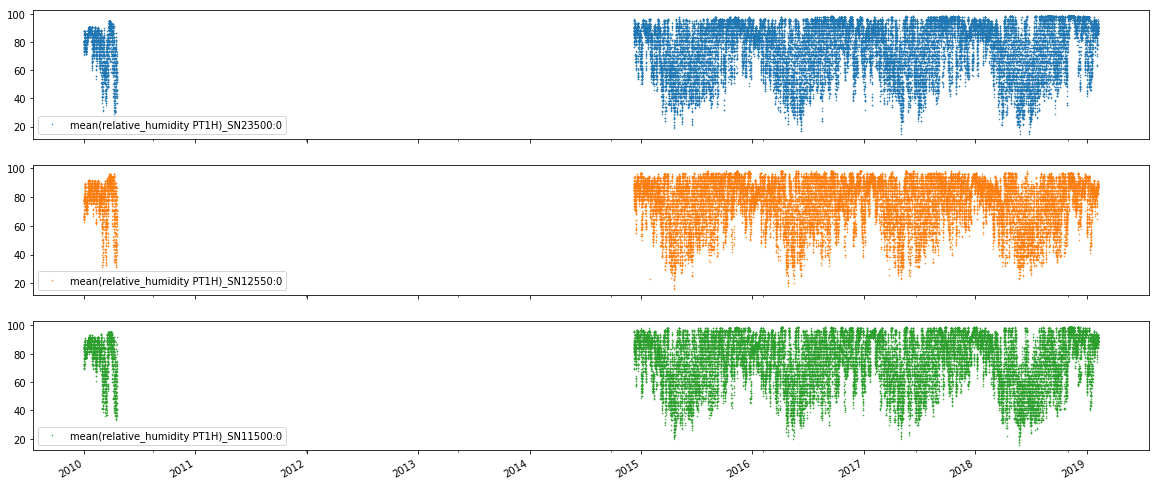

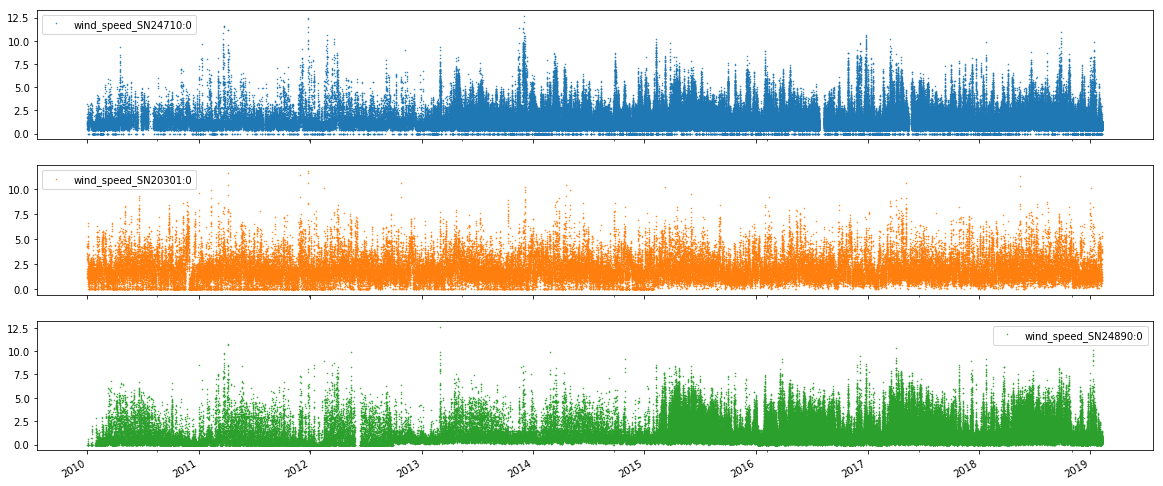

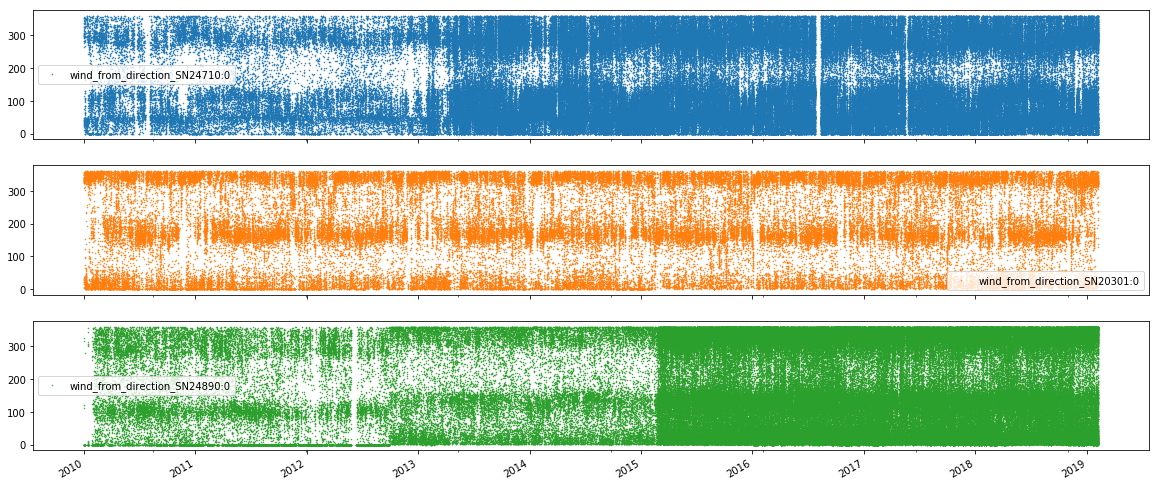

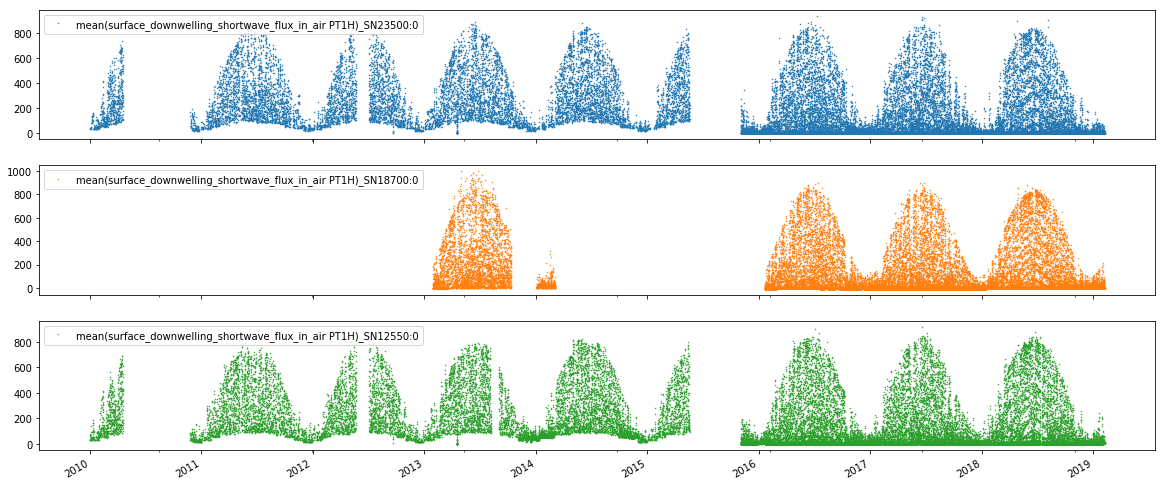

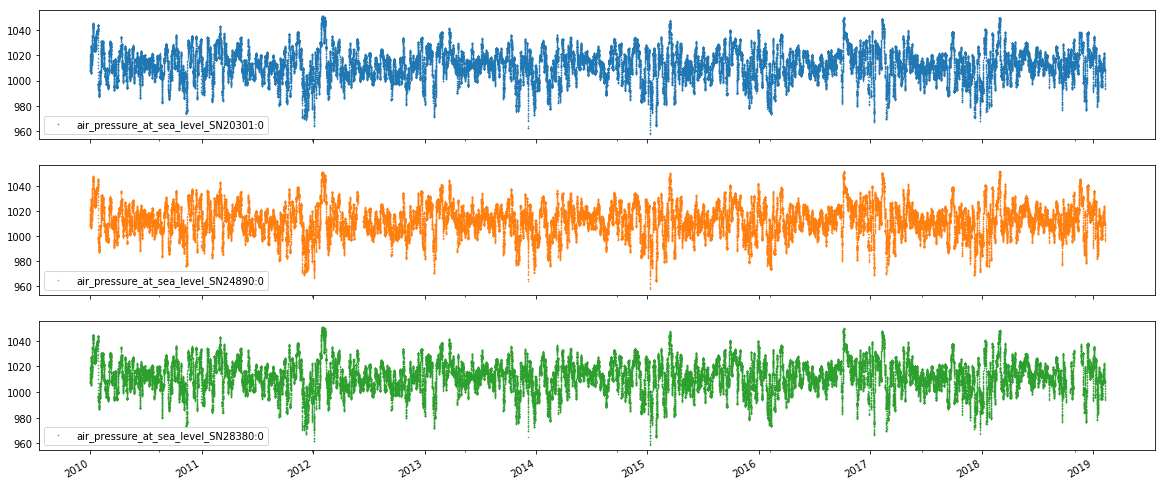

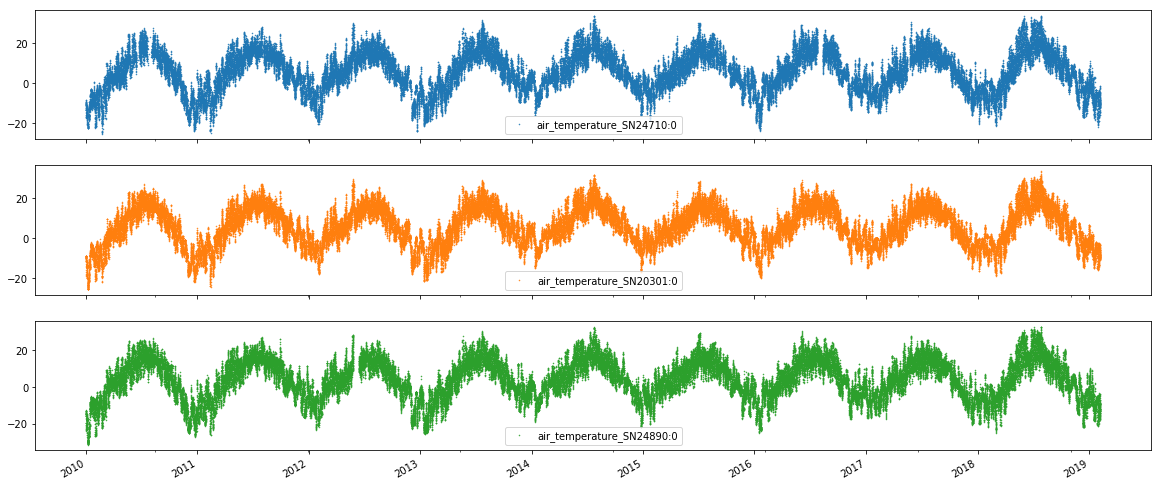

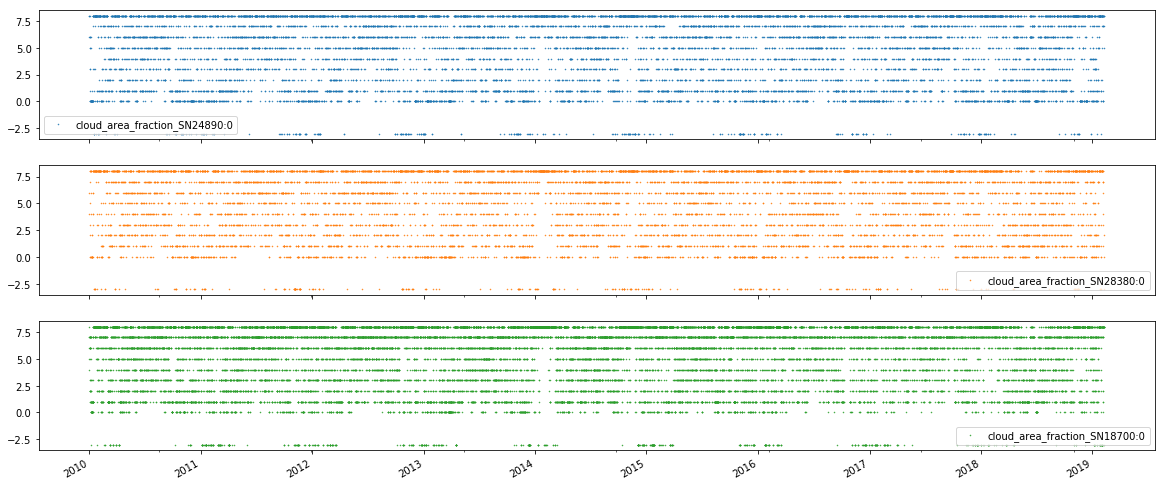

In [22]:
for key in allData:
    plotVar(key)

In [21]:
display(varStations)

{'humidity': [{'name': 'LØKEN I VOLBU',
   'location': [61.122, 9.063],
   'id': 'SN23500:0',
   'validFrom': '1987-06-01T00:00:00.000Z',
   'variable': 'mean(relative_humidity PT1H)',
   'distance': '110.30'},
  {'name': 'KISE PA HEDMARK',
   'location': [60.7733, 10.8055],
   'id': 'SN12550:0',
   'validFrom': '1982-01-01T00:00:00.000Z',
   'variable': 'mean(relative_humidity PT1H)',
   'distance': '127.15'},
  {'name': 'ØSTRE TOTEN - APELSVOLL',
   'location': [60.7002, 10.8695],
   'id': 'SN11500:0',
   'validFrom': '1987-03-19T00:00:00.000Z',
   'variable': 'mean(relative_humidity PT1H)',
   'distance': '131.41'}],
 'wind_speed': [{'name': 'GULSVIK II',
   'location': [60.383, 9.605],
   'id': 'SN24710:0',
   'validFrom': '2007-12-12T00:00:00.000Z',
   'variable': 'wind_speed',
   'distance': '13.51'},
  {'name': 'HØNEFOSS - HØYBY',
   'location': [60.1665, 10.2478],
   'id': 'SN20301:0',
   'validFrom': '2005-05-25T00:00:00.000Z',
   'variable': 'wind_speed',
   'distance': '61.9